GP training complete.


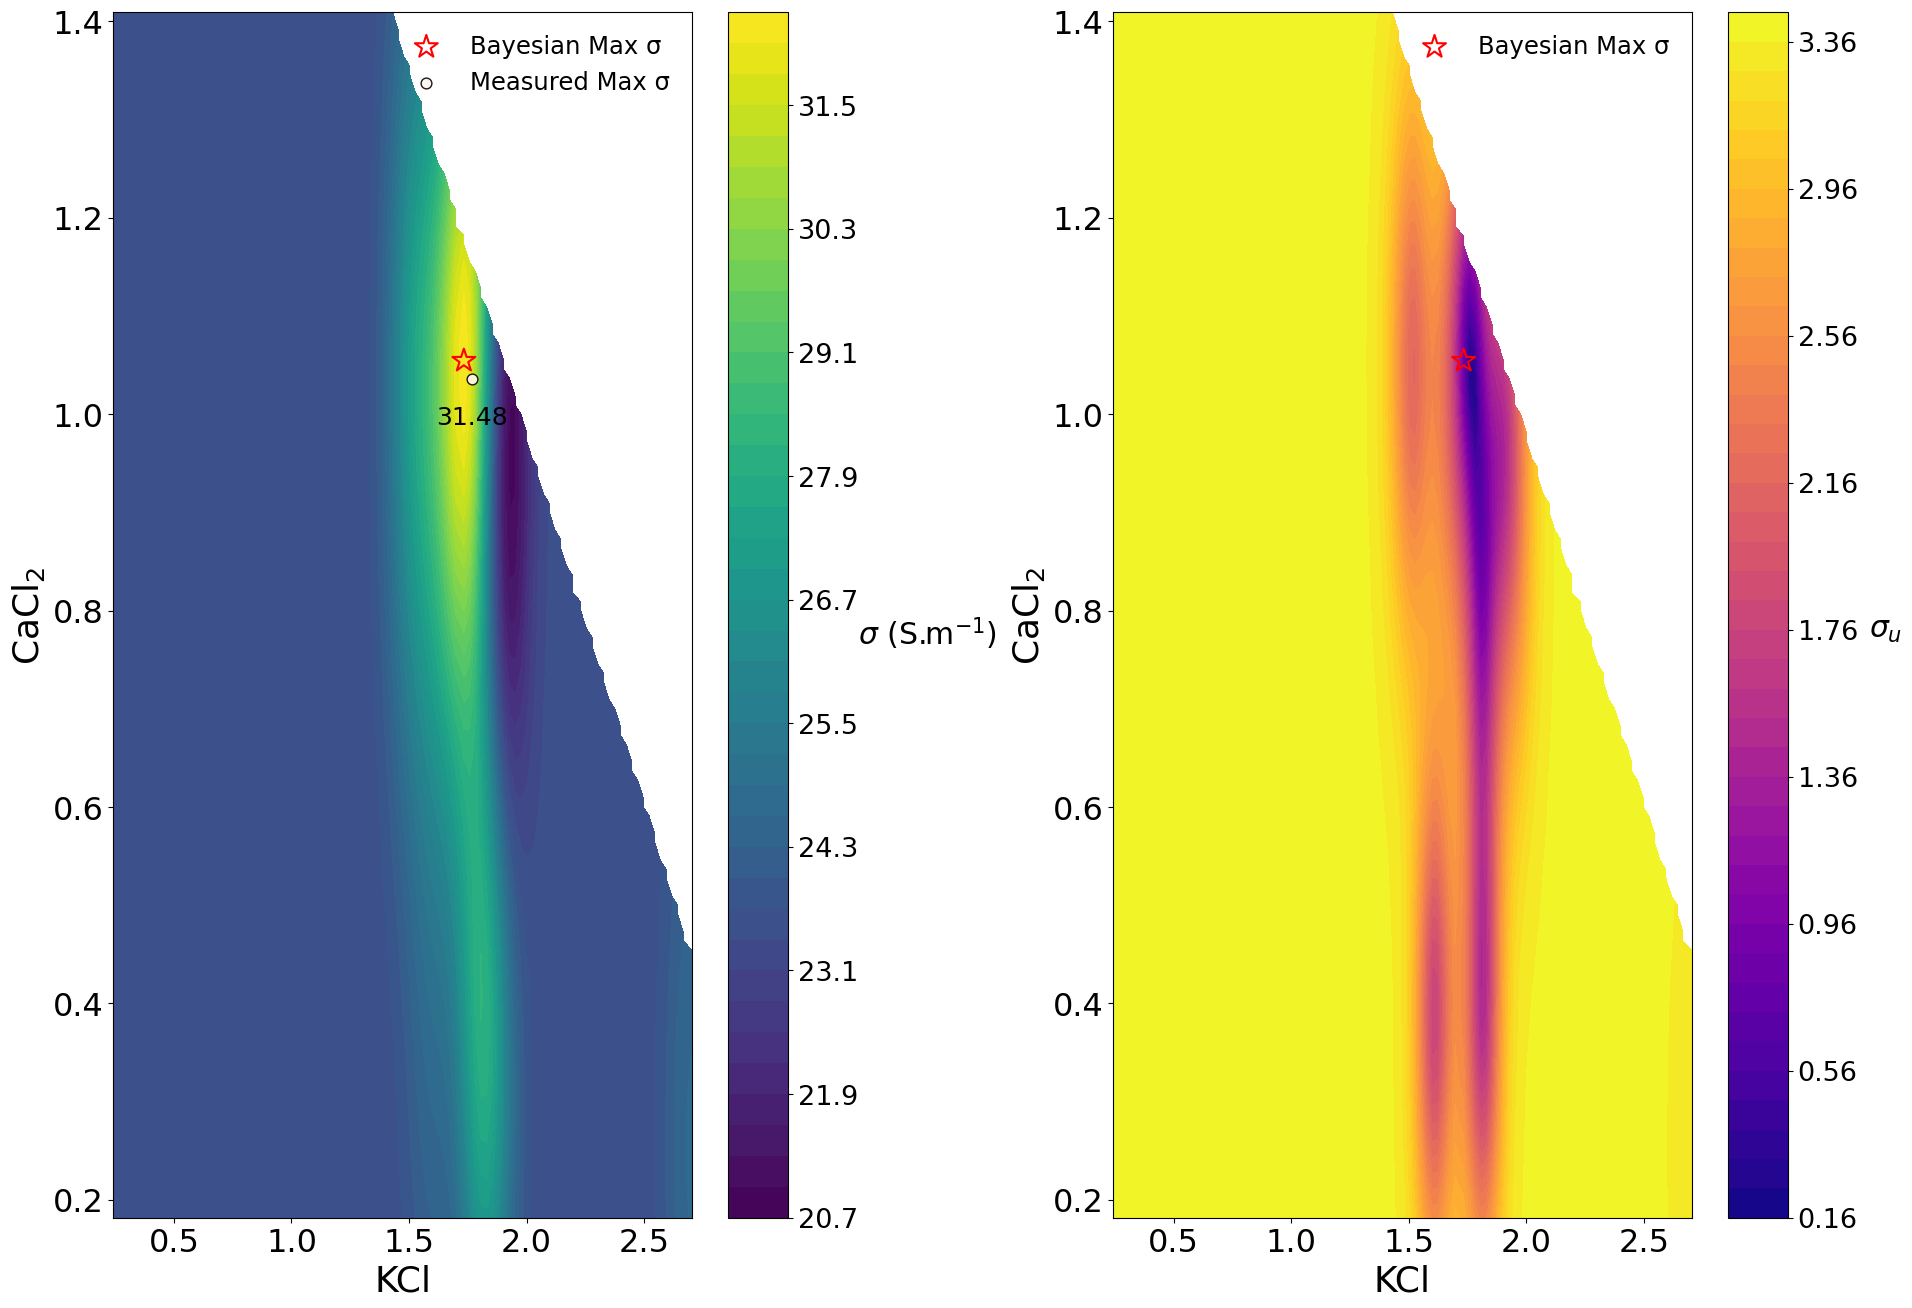

In [ ]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C


csv_file = "./candidates_camp1DD.csv"
df_full = pd.read_csv(csv_file)

# Drop any rows with NaN in objective_1
df_full = df_full.dropna(subset=["objective_1"])

# Train
X_train = df_full[["input_1", "input_2", "input_3", "input_4"]].values
y_train = df_full["objective_1"].values

# Define a GP kernel
kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=[10.0, 10.0, 10.0, 10.0],
                                   length_scale_bounds=(1e-2, 1e2))


gp = GaussianProcessRegressor(
    kernel=kernel,
    n_restarts_optimizer=5,
    alpha=1e-6,         #minute noise for numerical stability
    normalize_y=True,
    random_state=42
)

gp.fit(X_train, y_train)
print("GP training complete.")




# Create Slices
fix_vals = {"input_1": 28, "input_3": 29}
axis_x   = "input_2"   # KCl
axis_y   = "input_4"   # CaCl2
grid_pts = 100
max_sum  = 330

scale_x = 4.0 / 330.0    # KCl
scale_y = 3.0 / 330.0    # CaCl2

pretty_names = {
    "input_1": "NaCl",
    "input_2": "KCl",
    "input_3": "MgCl$_2$",
    "input_4": "CaCl$_2$"
}


x_min_data = int(df_full[axis_x].min())
x_max_data = int(df_full[axis_x].max())
y_min_data = int(df_full[axis_y].min())
y_max_data = int(df_full[axis_y].max())


xs = np.linspace(x_min_data, x_max_data, grid_pts, dtype=int)
ys = np.linspace(y_min_data, y_max_data, grid_pts, dtype=int)

Z_mu  = np.full((grid_pts, grid_pts), np.nan)
Z_sig = np.full((grid_pts, grid_pts), np.nan)


for i, xv in enumerate(xs):
    for j, yv in enumerate(ys):
        cfg_dict = {
            "input_1": fix_vals["input_1"],
            "input_2": xv,
            "input_3": fix_vals["input_3"],
            "input_4": yv
        }
        if sum(cfg_dict.values()) > max_sum:
            # Infeasible under sum inputs ≤ 330 → leave as NaN
            continue

        arr = np.array([[cfg_dict["input_1"],
                         cfg_dict["input_2"],
                         cfg_dict["input_3"],
                         cfg_dict["input_4"]]])
        mu_pred, sigma_pred = gp.predict(arr, return_std=True)

        Z_mu[j, i]  = mu_pred.item()
        Z_sig[j, i] = sigma_pred.item()

Xg, Yg = np.meshgrid(xs, ys)
Xg_scaled = Xg * scale_x
Yg_scaled = Yg * scale_y

ticksize  = 23
labelsize = 26
legsize   = 19.5

fig, ax = plt.subplots(1, 2, figsize=(19.2, 13.2))

c1 = ax[0].contourf(
    Xg_scaled, Yg_scaled, Z_mu,
    levels = 40,
    cmap   = "viridis"
)
cbar1 = fig.colorbar(c1, ax=ax[0])
cbar1.set_label(
    r"$\sigma$ (S.m$^{-1}$)", rotation=0,
    fontsize=legsize+2, labelpad=50
)
cbar1.ax.tick_params(labelsize=legsize)

ax[0].set_xlabel(pretty_names[axis_x], fontsize=labelsize)
ax[0].set_ylabel(pretty_names[axis_y], fontsize=labelsize)
ax[0].tick_params(labelsize=ticksize)
ax[0].set_xlim(x_min_data * scale_x, x_max_data * scale_x)
ax[0].set_ylim(y_min_data * scale_y, y_max_data * scale_y)

if np.isfinite(Z_mu).any():
    max_idx = np.unravel_index(np.nanargmax(Z_mu), Z_mu.shape)
    x_star  = Xg[max_idx] * scale_x
    y_star  = Yg[max_idx] * scale_y
    ax[0].scatter(
        x_star, y_star,
        s=300, marker='*',
        facecolors='none',
        edgecolors='red',
        linewidths=1.5,
        label = 'Bayesian Max σ'
    )
    ax[0].legend(loc="upper right", fontsize=legsize-2, frameon=False)

# ───Overlay actual measured points in that slice
slice_df = df_full[(df_full["input_1"] == fix_vals["input_1"]) &
                   (df_full["input_3"] == fix_vals["input_3"])]

ax[0].scatter(
    slice_df[axis_x] * scale_x,
    slice_df[axis_y] * scale_y,
    c = slice_df["objective_1"],
    cmap = "Reds",
    edgecolors = "black",
    s = 60,
    alpha = 0.9,
    label = "Measured Max σ"
)
for _, row in slice_df.iterrows():
    ax[0].text(
        row[axis_x] * scale_x,
        row[axis_y] * scale_y - 0.04,
        f"{row['objective_1']:.2f}",
        color='black', fontsize=18,
        ha='center', va='center'
    )
ax[0].legend(loc="upper right", fontsize=legsize-2, frameon=False)

# ─—Right panel: Predicted σ (uncertainty)
c2 = ax[1].contourf(
    Xg_scaled, Yg_scaled, Z_sig,
    levels = 40,
    cmap   = "plasma"
)
cbar2 = fig.colorbar(c2, ax=ax[1])
cbar2.set_label(
    r"$\sigma_u$", rotation=0,
    fontsize=legsize+2, labelpad=20
)
cbar2.ax.tick_params(labelsize=legsize)

ax[1].set_xlabel(pretty_names[axis_x], fontsize=labelsize)
ax[1].set_ylabel(pretty_names[axis_y], fontsize=labelsize)
ax[1].tick_params(labelsize=ticksize)
ax[1].set_xlim(x_min_data * scale_x, x_max_data * scale_x)
ax[1].set_ylim(y_min_data * scale_y, y_max_data * scale_y)

# ──Mark the same “max μ” location on σ‐panel
if np.isfinite(Z_mu).any():
    ax[1].scatter(
        x_star, y_star,
        s=300, marker='*',
        facecolors='none',
        edgecolors='red',
        linewidths=1.5,
        label = 'Bayesian Max σ'
    )
    ax[1].legend(loc="upper right", fontsize=legsize-2, frameon=False)

plt.tight_layout()
plt.show()

